In [1]:
# Import libraries
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch
from datasets import Dataset, DatasetDict, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from tqdm import tqdm, trange
tqdm.pandas()
import matplotlib.pyplot as plt
import seaborn as sns

2024-04-29 12:40:21.804267: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 12:40:21.804292: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 12:40:21.804921: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-29 12:40:21.808485: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 12:40:22.334210: W tensorflow/compiler/tf2

In [2]:
# Available device and GPU count
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Available device: ", device)
device_count = torch.cuda.device_count()
print("Number of available GPU: ", device_count)
if device_count > 0:
    print("Avialable GPUs: ")
for i in range(device_count):
    print(torch.cuda.get_device_name(i), end=' ')

Available device:  cuda
Number of available GPU:  1
Avialable GPUs: 
NVIDIA GeForce RTX 3090 

In [3]:
# Configurations
configs = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'data_path': './data/train.csv',
    'eval_path': './data/test.csv',
    'save_path': './models',
    'n_labels': 6,
    'tokenizer_name': 'distilbert-base-uncased',
    'model_name': 'distilbert-base-uncased',
    'MAX_LENGTH': 512,
    'BATCH_SIZE': 32,
    'EPOCHS': 50,
    'patience': 8,
    'learning_rate': 2e-5,
    'weight_decay': 0.001
    
}

In [4]:
# Read data
df = pd.read_csv(configs['data_path'])
df.drop(columns='essay_id', inplace=True)
df.rename(columns={'full_text': 'text', 'score': 'label'}, inplace=True)
df.head()

,text,label
0,Many people have car where they live. The thin...,3
1,I am a scientist at NASA that is discussing th...,3
2,People always wish they had the same technolog...,4
3,"We all heard about Venus, the planet without a...",4
4,"Dear, State Senator\n\nThis is a letter to arg...",3


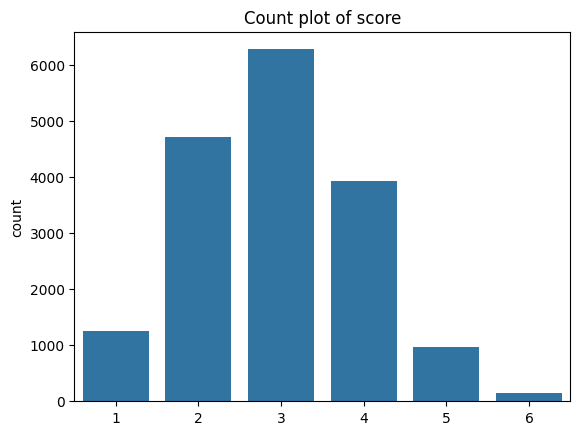

In [5]:
# Countplot of scores
sns.countplot(x=df['label'].to_list())
plt.title('Count plot of score')
plt.show()

In [6]:
# punkt 토크나이저 다운로드
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/yjg1005/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

100%|██████████| 17307/17307 [00:23<00:00, 724.33it/s]


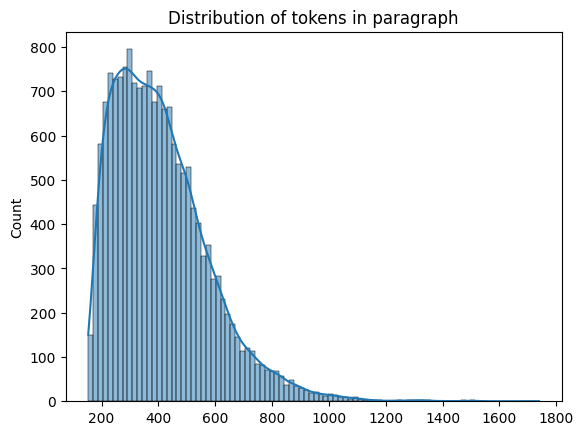

In [7]:
# Check distribution of number of taokens
n_tokens = df['text'].progress_apply(lambda x: len(word_tokenize(x))).to_list()
sns.histplot(n_tokens, kde=True)
plt.title('Distribution of tokens in paragraph')
plt.show()

In [8]:
# Split into train, val and test set
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df.label.values, random_state=32)
val_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df.label.values, random_state=32)

In [9]:
train_df.head()

,text,label
16972,The face on Mars is just a natural landform. T...,3
4074,A Facial Action Coding System is where it sees...,2
10679,"""The Challenge of Exploring Venus,"" is an arti...",4
15637,Ever heard of using technology to read student...,4
3859,Myths. Fables. Tall tales. What do they mean t...,6


In [10]:
# Create dataset from dataframe
dataset = DatasetDict()
dataset['train'] = Dataset.from_pandas(train_df)
dataset['val'] = Dataset.from_pandas(val_df)
dataset['test'] = Dataset.from_pandas(test_df)
dataset = dataset.remove_columns('__index_level_0__')
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 13845
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 1731
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1731
    })
})

In [11]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(configs['tokenizer_name'])

In [12]:
# Tokenize sentences
def tokenize(data):
    return tokenizer(data['text'], max_length=configs['MAX_LENGTH'], padding=True, truncation=True)

dataset['train'] = dataset['train'].map(tokenize, batched=True, batch_size=configs['BATCH_SIZE'])
dataset['val'] = dataset['val'].map(tokenize, batched=True, batch_size=configs['BATCH_SIZE'])

Map:   0%|          | 0/13845 [00:00<?, ? examples/s]

Map:   0%|          | 0/1731 [00:00<?, ? examples/s]

In [13]:
# Encode lables
def encode(data):
    data['label'] = np.eye(configs['n_labels'])[np.array(data['label']) - 1]
    return data

dataset['train'] = dataset['train'].map(encode, batched=True, batch_size=configs['BATCH_SIZE'])
dataset['val'] = dataset['val'].map(encode, batched=True, batch_size=configs['BATCH_SIZE'])

Map:   0%|          | 0/13845 [00:00<?, ? examples/s]

Map:   0%|          | 0/1731 [00:00<?, ? examples/s]

In [14]:
# Load Model
model = AutoModelForSequenceClassification.from_pretrained(configs['model_name'], num_labels=configs['n_labels'])
model = model.to(device)
model

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [15]:
# Define training arguments
args = TrainingArguments(
    configs['save_path'],
    evaluation_strategy='epoch',
    eval_steps=1,
    logging_strategy='epoch',
    logging_steps=1,
    logging_dir=os.path.join(configs['save_path'],'logs'),
    save_strategy = "epoch",
    save_steps=1,
    save_total_limit=3,
    num_train_epochs=configs['EPOCHS'],
    per_device_train_batch_size=configs['BATCH_SIZE'],
    per_device_eval_batch_size=configs['BATCH_SIZE'],
    learning_rate=configs['learning_rate'],
    weight_decay=configs['weight_decay'],
    metric_for_best_model='eval_loss',
    load_best_model_at_end=True,
    report_to='tensorboard'
)

In [16]:
# Declare a evaluation metric
metric = load_metric('accuracy')
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    references = np.argmax(labels, axis=-1)
    return metric.compute(predictions=predictions, references=references)

In [17]:
# Initialize trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['val'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience = configs['patience'])]
)

In [18]:
# Start training
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.323800,0.273228,0.601964
2,0.267500,0.262569,0.613518
3,0.245500,0.263268,0.618140
4,0.224100,0.278456,0.596765
5,0.190300,0.295897,0.600809
6,0.154000,0.332599,0.598498
7,0.120900,0.361849,0.597343
8,0.098700,0.409684,0.595609
9,0.080800,0.457882,0.587522
10,0.066300,0.503624,0.580012


TrainOutput(global_step=4330, training_loss=0.17719555694016242, metrics={'train_runtime': 1592.0828, 'train_samples_per_second': 434.808, 'train_steps_per_second': 13.599, 'total_flos': 1.83414196233216e+16, 'train_loss': 0.17719555694016242, 'epoch': 10.0})

In [19]:
# Evaluate model on text
predictions, labels = [], []
for i in trange(len(dataset['test']['text']), desc='Evaluating'):
    text = dataset['test']['text'][i]
    label = dataset['test']['label'][i]
    inputs = tokenizer(text, max_length=configs['MAX_LENGTH'], padding=True, truncation=True, return_tensors='pt').to(device)
    outputs = model(**inputs)
    pred = np.argmax(outputs['logits'].to('cpu').detach().numpy(), axis=-1)[0] + 1
    predictions.append(pred)
    labels.append(label)

Evaluating: 100%|██████████| 1731/1731 [00:12<00:00, 141.17it/s]


In [20]:
# Calcultae classification report
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           1       0.69      0.45      0.54       125
           2       0.65      0.65      0.65       473
           3       0.64      0.57      0.60       628
           4       0.54      0.83      0.66       393
           5       0.29      0.02      0.04        97
           6       0.00      0.00      0.00        15

    accuracy                           0.61      1731
   macro avg       0.47      0.42      0.42      1731
weighted avg       0.60      0.61      0.59      1731



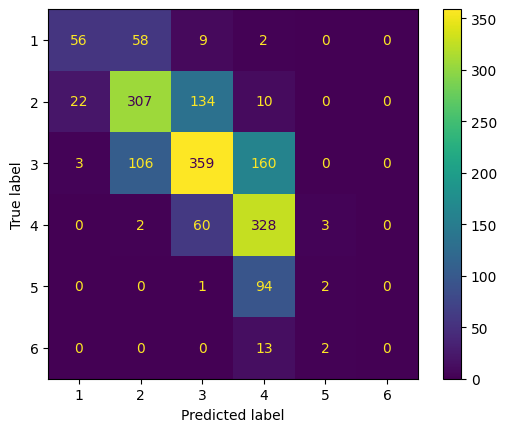

In [21]:
# Plot confusion matrix
cm = confusion_matrix(labels, predictions, labels=list(set(labels)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(labels)))
disp.plot()
plt.show()

In [25]:
df_test = pd.read_csv(configs['eval_path'])
df_test

,essay_id,full_text
0,000d118,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...
2,001ab80,People always wish they had the same technolog...


In [32]:
# Evaluate model on text
test_predictions = []
for i in df_test.index:
    text = df_test.loc[i, 'full_text']
    inputs = tokenizer(text, max_length=configs['MAX_LENGTH'], padding=True, truncation=True, return_tensors='pt').to(device)
    outputs = model(**inputs)
    pred = np.argmax(outputs['logits'].to('cpu').detach().numpy(), axis=-1)[0] + 1
    test_predictions.append(pred)
df_test['prediction'] = test_predictions

In [33]:
df_test

,essay_id,full_text,prediction
0,000d118,Many people have car where they live. The thin...,2
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
